In [1]:
%load_ext autoreload
%autoreload 2

# from controllers import plan_trajectory
import gym
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plan_trajectory(env, T=20):
    # parameterize trajectory with respect to time
    waypoints = np.array(env.track)

    waypoint_count = waypoints.shape[0]

    dx = np.sqrt((waypoints[1, 2] - waypoints[0, 2])**2 + (waypoints[1, 3] - waypoints[0, 3])**2)
    start_acceleration = np.array([ 0.        ,  0.06796172,  0.15510417,  0.26017401,  0.38286151,
        0.52308393,  0.68082381,  0.85607584,  1.04883621,  1.25910493,
        1.48688352,  1.73217046,  1.99496954,  2.27527849,  2.57309578,
        2.88842143,  3.22125542,  3.57160308,  3.93945908,  4.32482344,
        4.72769614,  5.14807719,  5.5859719 ,  6.04137496,  6.51428637,
        7.00470613,  7.51263803,  8.03807828,  8.58102688,  9.14148535,
        9.71945216, 10.31493112, 10.92791843, 11.55841408, 12.20642036,
       12.87194031, 13.5549648 , 14.25549765, 14.97354264, 15.70909597,
       16.46215766, 17.23272997, 18.02081063, 18.82639964, 19.64950079,
       20.49010878, 21.3482289 , 22.22385738, 23.11699458, 24.02764204,
       24.95579822, 25.90146313, 26.86463715, 27.84532293, 28.84351593,
       29.85921956, 30.89243381, 31.9431568 , 33.0113889 , 34.09713201,
       35.20038082, 36.32114217, 37.45941263, 38.61519259, 39.78848301,
       40.97928047, 42.18758838, 43.41340714, 44.6567324 , 45.91756945])

    #midpoint_idx = list((start_acceleration[1:] - start_acceleration[:-1]) > 1).index(True)


    for idx, dist in enumerate(start_acceleration):
        num_step = int(T/env.dt)
        N = num_step - idx
        M = waypoint_count - dist / dx
        if (start_acceleration[idx+1] - start_acceleration[idx]) >= M/N * dx:
            break

    mid_idx = idx
    mid_dist = dist

    print(mid_idx, "/", len(start_acceleration))

    trajectory = np.zeros((num_step, 6))

    # print(num_step)
    # print(start_acceleration / dx)

    for idx, dist in enumerate(start_acceleration[:mid_idx+1]):
        j = int(dist/dx)
        alpha = dist/dx - j
        theta, x, y = (1-alpha)*waypoints[j, 1:] + alpha*waypoints[(j+1) % num_step, 1:]
        theta = (theta + np.pi/2) % (2*np.pi)
        trajectory[idx, :3] = [x, y, theta]

#     print(mid_dist/dx, num_step)
#     print(waypoint_count, M)
    print(mid_dist/dx + (N-1) * M / N)
    print(waypoint_count)
    for i in range(1, N):
        j = int(mid_dist/dx + i * M / N)
        alpha = mid_dist/dx + i * M / N - j
        # print(i, "/", N)
        theta, x, y = (1-alpha)*waypoints[j, 1:] + alpha*waypoints[(j+1) % waypoint_count, 1:]
        theta = (theta + np.pi/2) % (2*np.pi)
        trajectory[mid_idx + i, :3] = [x, y, theta]

    # target velocities
    for i in range(num_step):
        v_x, v_y, omega = (trajectory[(i+1) % num_step, :3] - trajectory[i, :3]) / env.dt
        trajectory[i, 3:] = [v_x, v_y, omega]

    return trajectory


In [3]:
gym.logger.set_level(gym.logger.ERROR)
env = gym.make('CarRacing-v1', seed=0xc4c3b3d54fd64f0b).env
Z_0 = env.reset()
states, actions, observations = [], [], []
done = False

In [4]:
trajectory = plan_trajectory(env)
len(trajectory), trajectory

47 / 70
244.74957993025933
245


(1000,
 array([[ 2.19262518e+02, -5.47430118e+01,  1.46562388e+00,
          3.56726518e-01,  3.37930979e+00,  0.00000000e+00],
        [ 2.19269653e+02, -5.46754256e+01,  1.46562388e+00,
          4.57404885e-01,  4.33304711e+00,  0.00000000e+00],
        [ 2.19278801e+02, -5.45887646e+01,  1.46562388e+00,
          5.51504555e-01,  5.22446370e+00,  0.00000000e+00],
        ...,
        [ 2.18710454e+02, -5.99727755e+01,  1.46562388e+00,
          9.20106715e+00,  8.71627286e+01, -1.68470793e-09],
        [ 2.18894476e+02, -5.82295209e+01,  1.46562388e+00,
          9.20106715e+00,  8.71627286e+01, -1.68470793e-09],
        [ 2.19078497e+02, -5.64862664e+01,  1.46562388e+00,
          9.20106715e+00,  8.71627286e+01, -1.68471903e-09]]))

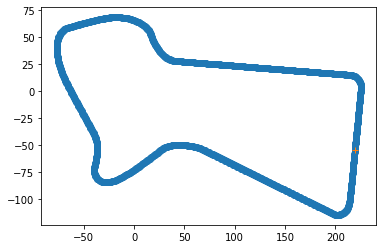

In [5]:
track = trajectory[:, :3]
plt.plot(track[:, 0], track[:, 1], '-o')
plt.plot(Z_0[0], Z_0[1], '+')
plt.show()

In [6]:
# from planning import plan_trajectory as pt

# _trajectory = pt(env)
# len(_trajectory), _trajectory

# _track = _trajectory[:, :3]
# plt.plot(_track[:120, 0], _track[:120, 1], '-o')
# plt.plot(Z_0[0], Z_0[1], '+')
# plt.show()

In [7]:
Z_0, track[0, :]

(array([ 2.19262177e+02, -5.47429695e+01,  1.47071041e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -5.08652627e-03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]),
 array([219.26251845, -54.74301179,   1.46562388]))

In [8]:
# from casadi import *

# # track = trajectory[:, :3]
# z_ref = MX(track.T)
# N = z_ref.shape[1]

# Q = MX(np.diag([1, 1, 1]))
# R = MX(np.eye(2)) / 100000

# dt = 0.02
# l = 1

In [9]:
# opti = casadi.Opti();

# z = MX(4, N);
# # opti.set_initial(z[:3, :], track.T)
# z[:3, 0] == z_ref[:, 0]

# u = opti.variable(2, N-1);
# u_init = np.tile([[0], [.5]], (1, N-1))
# opti.set_initial(u, u_init)

# cost = 0

# for i in range(N-1):
#     cost += (z[:3, i] - z_ref[:, i]).T @ Q @ (z[:3, i] - z_ref[:, i]) + u[:, i].T @ R @ u[:, i]
    
#     z[0, i+1] = z[0, i] + u[0, i] * np.cos(z[2, i]) * dt
#     z[1, i+1] = z[1, i] + u[0, i] * np.sin(z[2, i]) * dt
#     z[2, i+1] = z[2, i] + u[0, i] / l * np.tan(z[3, i]) * dt
#     z[3, i+1] = z[3, i] + u[1, i] * dt

# cost += (z[:3, N-1] - z_ref[:, N-1]).T @ Q @ (z[:3, N-1] - z_ref[:, N-1])

# opti.minimize(cost);
# # opti.subject_to(-1 <= u[0, :] <= 1);
# # opti.subject_to(-1 <= z[2, :] <= 1);
# # opti.subject_to(-3 <= u[1, :] <= 3);
# # opti.subject_to(0 <= u[2, :] <= 1);

# opti.solver('ipopt');

# sol = opti.solve();

In [10]:
# u_opt = sol.value(u)
# z_opt = sol.value(z)

# zs = z_opt.toarray().T

# plt.plot(track[:, 0], track[:, 1], '-o')
# plt.plot(zs[0, :], zs[1, :], '-+')
# plt.show()

In [11]:
# env.car.hull.mass

In [12]:
# env.car.hull.inertia

In [13]:
# opti = casadi.Opti();

# z = MX(4, N);
# # opti.set_initial(z[:3, :], track.T)
# z[:3, 0] == z_ref[:, 0]

# u = opti.variable(2, N-1);
# u_init = np.tile([[0], [.5]], (1, N-1))
# opti.set_initial(u, u_init)

# cost = 0

# for i in range(N-1):
#     cost += (z[:3, i] - z_ref[:, i]).T @ Q @ (z[:3, i] - z_ref[:, i]) + u[:, i].T @ R @ u[:, i]
    
#     z[0, i+1] = z[0, i] + u[0, i] * np.cos(z[2, i]) * dt
#     z[1, i+1] = z[1, i] + u[0, i] * np.sin(z[2, i]) * dt
#     z[2, i+1] = z[2, i] + u[0, i] / l * np.tan(z[3, i]) * dt
#     z[3, i+1] = z[3, i] + u[1, i] * dt

# cost += (z[:3, N-1] - z_ref[:, N-1]).T @ Q @ (z[:3, N-1] - z_ref[:, N-1])

# opti.minimize(cost);
# # opti.subject_to(-1 <= u[0, :] <= 1);
# # opti.subject_to(-1 <= z[2, :] <= 1);
# # opti.subject_to(-3 <= u[1, :] <= 3);
# # opti.subject_to(0 <= u[2, :] <= 1);

# opti.subject_to(u[:, 0] == 0)

# opti.solver('ipopt');

# sol = opti.solve();

In [14]:
# zs.shape

In [15]:
# print(u_opt)

In [16]:
# u_T = u_opt.T
# racecar_action = np.zeros((N-1, 3))  # third coumn is brake. It is null because 
# # it is not in the bicycle model used in the optimization solve
# racecar_action[:, 0] = z_opt.T[:-1, 3]  # steering
# racecar_action[:, 1] = u_T[:, 0]  # throttle

# racecar_action

In [17]:
def f(z, u, model):
    tensor = vertcat(z, u)
    layers = model.get_weights()
    L = len(layers)

    for i in range(0, L, 2):
        weight, bias = MX(layers[i].T), MX(layers[i+1])

        if i < L-2:
            tensor = tanh(weight @ tensor + bias)
        else:
            tensor = weight @ tensor + bias

    return tensor

In [18]:
from learning import load_model

Using TensorFlow backend.


In [19]:
model = load_model("../models/dynamics128.h5")

[learning.py] loading model (../models/dynamics128.h5)
__________________________________________________________________________________________________
Model: "dynamics"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z (InputLayer)                  (None, 6)            0                                            
__________________________________________________________________________________________________
u (InputLayer)                  (None, 3)            0                                            
__________________________________________________________________________________________________
input_layer (Concatenate)       (None, 9)            0           z[0][0]                          
                                                                 u[0][0]                          
____________________________________

In [20]:
from casadi import *

P = MX(np.diag([10, 10, 10]))
Q = MX(np.diag([3, 3, 1]))
R = MX(np.eye(3))

dt = 0.02

In [21]:
def optimize(track, z_0):
    opti = casadi.Opti();
    
    z_ref = MX(track)
    N = track.shape[1]

    u = opti.variable(3, N-1);
    u_init = np.tile([[0], [.5], [0]], (1, N-1))
    opti.set_initial(u, u_init)

    z = MX(6, N)
    z[:, 0] = z_0
    cost = 0

    for i in range(N-1):
        cost += (z[:3, i] - z_ref[:, i]).T @ Q @ (z[:3, i] - z_ref[:, i]) + u[:, i].T @ R @ u[:, i]
        z[:3, i+1] = z[:3, i] + z[3:, i] * dt
        z[3:, i+1] = z[3:, i] + f(z[:, i], u[:, i], model) * dt

    cost += (z[:3, N-1] - z_ref[:, N-1]).T @ P @ (z[:3, N-1] - z_ref[:, N-1])

    opti.minimize(cost);

    opti.solver('ipopt');

    sol = opti.solve();
    
    return sol.value(u), sol.value(z)

In [22]:
# u_opt, zs = optimize()

# plt.plot(track[:, 0], track[:, 1], '-o')
# plt.plot(zs[:, 0], zs[:, 1], '-+')
# plt.show()

In [23]:
z_0 = Z_0[:6]

zs = z_0.reshape(6, 1)
us = np.zeros((3, 0))

didx = 20
a = 0
b = len(trajectory) // 20
for j in range(a, b):
    track = trajectory[didx*j:didx*j+didx+1, :3].T
    u_opt, z_opt = optimize(track, z_0)
    z_0 = z_opt[:, -1]
    zs = np.hstack((zs, z_opt[:, 1:]))
    us = np.hstack((us, u_opt))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  27  2.5226892e+00 0.00e+00 2.71e-01  -1.7 8.02e-03   1.5 1.00e+00 1.00e+00f  1
  28  2.2538756e+00 0.00e+00 2.30e+00  -1.7 2.23e-02   1.1 1.00e+00 1.00e+00f  1
  29  2.1578481e+00 0.00e+00 3.66e-01  -1.7 8.11e-03   1.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.9294093e+00 0.00e+00 6.30e-01  -1.7 2.23e-02   1.0 1.00e+00 1.00e+00f  1
  31  1.4914164e+00 0.00e+00 2.42e+00  -1.7 5.27e-02   0.5 1.00e+00 1.00e+00f  1
  32  1.4697012e+00 0.00e+00 1.74e-01  -1.7 2.44e-03   1.9 1.00e+00 1.00e+00f  1
  33  1.4695855e+00 0.00e+00 1.73e-01  -2.5 6.36e+01    -  1.00e+00 4.88e-04f 12
  34  1.0267617e+00 0.00e+00 7.43e+00  -2.5 2.67e-01    -  1.00e+00 1.00e+00f  1
  35  9.7411371e-01 0.00e+00 3.20e-01  -2.5 1.97e-03   2.3 1.00e+00 1.00e+00f  1
  36  9.5825056e-01 0.00e+00 2.69e-01  -2.5 4.25e-03   1.8 1.00e+00 1.00e+00f  1
  37  9.3451346e-01 0.00e+00 2.59e-01  -2.5 1.23e-02   1.3 1.00e+00 1.00e+00f  1
  38  8.9357074e-01 0.00e+00

  29  5.9378772e+00 0.00e+00 8.46e-02  -2.5 2.16e-02   0.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  5.6193333e+00 0.00e+00 5.96e-01  -2.5 1.51e-01   0.1 1.00e+00 1.00e+00f  1
  31  5.4945895e+00 0.00e+00 7.18e-02  -2.5 2.02e-02   0.5 1.00e+00 1.00e+00f  1
  32  5.3466772e+00 0.00e+00 4.32e-02  -2.5 4.06e-02   0.0 1.00e+00 1.00e+00f  1
  33  5.1161872e+00 0.00e+00 2.14e-01  -2.5 1.21e-01  -0.4 1.00e+00 1.00e+00f  1
  34  4.9628807e+00 0.00e+00 5.73e-02  -2.5 1.01e-01  -0.9 1.00e+00 1.00e+00f  1
  35  4.9459730e+00 0.00e+00 1.06e-02  -2.5 2.37e-02  -0.5 1.00e+00 1.00e+00f  1
  36  4.9425597e+00 0.00e+00 6.99e-03  -3.8 7.95e-03  -0.1 1.00e+00 1.00e+00f  1
  37  4.9298089e+00 0.00e+00 2.66e-02  -3.8 4.90e-02  -0.5 1.00e+00 1.00e+00f  1
  38  4.9004867e+00 0.00e+00 5.13e-02  -3.8 6.94e-02  -0.1 1.00e+00 1.00e+00f  1
  39  4.8900714e+00 0.00e+00 1.83e-01  -3.8 1.65e-01  -0.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

   3  3.8711806e+02 0.00e+00 8.25e+01  -1.0 6.97e-02   3.0 1.00e+00 1.00e+00f  1
   4  3.6605010e+02 0.00e+00 1.40e+02  -1.0 4.33e-02   3.5 1.00e+00 1.00e+00f  1
   5  3.5485659e+02 0.00e+00 1.72e+02  -1.0 2.18e-02   3.9 1.00e+00 1.00e+00f  1
   6  2.8281596e+02 0.00e+00 2.71e+02  -1.0 1.32e-01   3.4 1.00e+00 1.00e+00f  1
   7  2.4947769e+02 0.00e+00 3.62e+02  -1.0 5.06e-02   3.8 1.00e+00 1.00e+00f  1
   8  1.1486147e+02 0.00e+00 1.72e+02  -1.0 5.04e-01   3.4 1.00e+00 1.00e+00f  1
   9  1.0210342e+02 0.00e+00 2.03e+02  -1.0 3.28e-02   3.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.5349861e+01 0.00e+00 1.27e+02  -1.0 1.59e-01   3.3 1.00e+00 1.00e+00f  1
  11  4.3222154e+01 0.00e+00 1.09e+02  -1.0 9.49e+00   2.8 1.00e+00 1.25e-01f  4
  12  2.7872299e+01 0.00e+00 9.77e+01  -1.0 9.61e-02   3.3 1.00e+00 1.00e+00f  1
  13  1.8670417e+01 0.00e+00 5.74e+01  -1.0 7.21e-02   2.8 1.00e+00 1.00e+00f  1
  14  1.3048284e+01 0.00e+00

  23  1.0899515e+00 0.00e+00 1.09e+00  -1.7 4.14e-02   0.7 1.00e+00 1.00e+00f  1
  24  1.0082268e+00 0.00e+00 2.03e-01  -1.7 1.42e-02   1.2 1.00e+00 1.00e+00f  1
  25  8.8289996e-01 0.00e+00 1.79e+01  -1.7 1.56e-01    -  1.00e+00 1.00e+00f  1
  26  6.1893175e-01 0.00e+00 2.42e-01  -1.7 6.41e-03   2.5 1.00e+00 1.00e+00f  1
  27  6.1792956e-01 0.00e+00 6.75e-02  -1.7 6.64e-04   2.0 1.00e+00 1.00e+00f  1
  28  6.1742484e-01 0.00e+00 4.03e-02  -2.5 1.18e-03   1.5 1.00e+00 1.00e+00f  1
  29  6.1564477e-01 0.00e+00 2.48e-01  -2.5 2.56e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  6.1518557e-01 0.00e+00 1.02e-02  -2.5 8.72e-04   1.1 1.00e+00 1.00e+00f  1
  31  6.1512788e-01 0.00e+00 7.66e-03  -3.8 1.96e-03   0.6 1.00e+00 1.00e+00f  1
  32  6.1503416e-01 0.00e+00 2.56e-02  -3.8 5.63e-03   0.1 1.00e+00 1.00e+00f  1
  33  6.1483543e-01 0.00e+00 3.70e-01  -3.8 2.06e-02  -0.4 1.00e+00 1.00e+00f  1
  34  6.1457851e-01 0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  19  3.3713246e+00 0.00e+00 8.46e-01  -1.7 1.38e-02   1.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.7711559e+00 0.00e+00 1.29e+00  -1.7 3.14e-02   1.3 1.00e+00 1.00e+00f  1
  21  1.9205652e+00 0.00e+00 1.88e+00  -1.7 6.35e-02   0.8 1.00e+00 1.00e+00f  1
  22  1.6718935e+00 0.00e+00 4.94e-01  -1.7 2.17e-02   1.2 1.00e+00 1.00e+00f  1
  23  5.4432636e-01 0.00e+00 4.83e+00  -1.7 3.34e-01    -  1.00e+00 5.00e-01f  2
  24  4.4390777e-01 0.00e+00 2.46e-01  -1.7 5.23e-03   1.6 1.00e+00 1.00e+00f  1
  25  1.6962013e-01 0.00e+00 1.76e+00  -1.7 1.63e-01    -  1.00e+00 5.00e-01f  2
  26  1.2345504e-01 0.00e+00 1.22e-01  -1.7 1.58e-02   1.2 1.00e+00 1.00e+00f  1
  27  9.3241300e-02 0.00e+00 6.60e-02  -2.5 1.37e-02   0.7 1.00e+00 1.00e+00f  1
  28  3.8970774e-02 0.00e+00 5.87e-01  -2.5 6.86e-02    -  1.00e+00 1.00e+00f  1
  29  2.8551557e-02 0.00e+00 4.73e-02  -2.5 1.71e-02   0.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

   4  6.3565224e+00 0.00e+00 1.16e+00  -1.0 2.73e-02   1.5 1.00e+00 1.00e+00f  1
   5  5.5439770e+00 0.00e+00 5.77e-01  -1.0 3.64e-02   1.0 1.00e+00 1.00e+00f  1
   6  4.1779785e+00 0.00e+00 1.97e+00  -1.7 9.89e-02   0.5 1.00e+00 1.00e+00f  1
   7  3.7331605e+00 0.00e+00 8.51e-01  -1.7 4.43e-02   0.9 1.00e+00 1.00e+00f  1
   8  3.5815895e+00 0.00e+00 3.56e-01  -1.7 1.50e-02   1.4 1.00e+00 1.00e+00f  1
   9  3.1782111e+00 0.00e+00 3.59e-01  -1.7 4.57e-02   0.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.8715768e+00 0.00e+00 8.07e+00  -1.7 1.16e-01   0.4 1.00e+00 5.00e-01f  2
  11  2.6738052e+00 0.00e+00 2.42e+00  -1.7 3.63e-02   1.7 1.00e+00 1.00e+00f  1
  12  2.6011519e+00 0.00e+00 3.89e+00  -1.7 8.05e-02   1.3 1.00e+00 5.00e-01f  2
  13  2.5129422e+00 0.00e+00 3.19e-01  -1.7 6.48e-03   1.7 1.00e+00 1.00e+00f  1
  14  2.3696645e+00 0.00e+00 3.11e-01  -1.7 1.88e-02   1.2 1.00e+00 1.00e+00f  1
  15  1.9981233e+00 0.00e+00

  31  1.3370685e-01 0.00e+00 7.43e-01  -2.5 8.65e-03   0.5 1.00e+00 1.00e+00f  1
  32  1.3323552e-01 0.00e+00 6.71e-02  -2.5 1.86e-03   0.9 1.00e+00 1.00e+00f  1
  33  1.3277700e-01 0.00e+00 2.41e-01  -2.5 3.78e-03   0.5 1.00e+00 1.00e+00f  1
  34  1.3240007e-01 0.00e+00 2.13e-01  -2.5 1.39e-02  -0.0 1.00e+00 1.00e+00f  1
  35  1.3221017e-01 0.00e+00 1.21e-01  -2.5 5.36e-03   0.4 1.00e+00 1.00e+00f  1
  36  1.3193964e-01 0.00e+00 4.73e-01  -2.5 1.63e-02  -0.1 1.00e+00 1.00e+00f  1
  37  1.3184724e-01 0.00e+00 3.96e-03  -2.5 1.01e-03   0.4 1.00e+00 1.00e+00f  1
  38  1.3180754e-01 0.00e+00 2.07e-01  -3.8 5.63e-03  -0.1 1.00e+00 1.00e+00f  1
  39  1.3132296e-01 0.00e+00 3.67e-01  -3.8 5.88e-02  -0.6 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.3079106e-01 0.00e+00 3.64e-02  -3.8 3.02e-03   0.7 1.00e+00 1.00e+00f  1
  41  1.3064564e-01 0.00e+00 6.63e-01  -3.8 2.21e-02    -  1.00e+00 5.00e-01f  2
  42  1.3049389e-01 0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.8528983e+00 0.00e+00 3.51e-01  -2.5 5.81e-02   0.1 1.00e+00 1.00e+00f  1
  31  1.6904261e+00 0.00e+00 1.12e-01  -2.5 1.99e-02   0.5 1.00e+00 1.00e+00f  1
  32  1.3646015e+00 0.00e+00 5.77e-01  -2.5 4.71e-02   0.0 1.00e+00 1.00e+00f  1
  33  1.2709948e+00 0.00e+00 4.77e-02  -2.5 1.60e-02   0.5 1.00e+00 1.00e+00f  1
  34  1.0962060e+00 0.00e+00 2.52e+00  -2.5 3.77e-02  -0.0 1.00e+00 1.00e+00f  1
  35  1.0818607e+00 0.00e+00 3.68e-02  -2.5 1.73e-03   1.3 1.00e+00 1.00e+00f  1
  36  1.0616279e+00 0.00e+00 3.54e-02  -2.5 5.02e-03   0.8 1.00e+00 1.00e+00f  1
  37  1.0342845e+00 0.00e+00 6.69e-01  -2.5 9.36e-01    -  1.00e+00 2.50e-01f  3
  38  1.0254478e+00 0.00e+00 7.84e-02  -2.5 4.18e-03   1.3 1.00e+00 1.00e+00f  1
  39  1.0060877e+00 0.00e+00 7.43e-02  -2.5 1.19e-02   0.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  9.6091867e-01 0.00e+00

  48  3.3936625e+00 0.00e+00 9.90e+00  -1.7 7.66e-02  -0.4 1.00e+00 1.00e+00f  1
  49  3.3448761e+00 0.00e+00 6.46e-01  -1.7 1.25e-03   2.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  3.3436985e+00 0.00e+00 1.60e-01  -1.7 7.50e-04   2.3 1.00e+00 1.00e+00f  1
  51  3.3424355e+00 0.00e+00 9.88e-02  -2.5 1.26e-03   1.8 1.00e+00 1.00e+00f  1
  52  3.3403980e+00 0.00e+00 5.60e-02  -2.5 2.28e-03   1.3 1.00e+00 1.00e+00f  1
  53  3.3359167e+00 0.00e+00 7.12e-02  -2.5 6.57e-03   0.9 1.00e+00 1.00e+00f  1
  54  3.3271734e+00 0.00e+00 3.00e-01  -2.5 1.75e-02   0.4 1.00e+00 1.00e+00f  1
  55  3.3245103e+00 0.00e+00 4.31e-02  -2.5 5.86e-03   0.8 1.00e+00 1.00e+00f  1
  56  3.3188308e+00 0.00e+00 3.03e-01  -2.5 1.51e-02   0.3 1.00e+00 1.00e+00f  1
  57  3.3166817e+00 0.00e+00 5.09e-02  -2.5 5.33e-03   0.8 1.00e+00 1.00e+00f  1
  58  3.3048644e+00 0.00e+00 1.75e+00  -2.5 3.64e-01   0.3 1.00e+00 1.25e-01f  4
  59  3.3029717e+00 0.00e+00

  46  4.2558514e-01 0.00e+00 4.44e-01  -2.5 6.25e-03  -0.6 1.00e+00 1.00e+00f  1
  47  4.2464521e-01 0.00e+00 2.69e-01  -2.5 6.85e-02  -1.1 1.00e+00 2.50e-01f  3
  48  4.2328030e-01 0.00e+00 1.35e-02  -2.5 1.00e-02    -  1.00e+00 1.00e+00f  1
  49  4.2303508e-01 0.00e+00 4.17e-02  -3.8 1.13e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  4.2292720e-01 0.00e+00 1.85e-03  -3.8 2.67e-03    -  1.00e+00 1.00e+00f  1
  51  4.2290301e-01 0.00e+00 1.01e-02  -3.8 1.35e-02    -  1.00e+00 5.00e-01f  2
  52  4.2288235e-01 0.00e+00 2.14e-03  -3.8 3.31e-03    -  1.00e+00 1.00e+00f  1
  53  4.2287629e-01 0.00e+00 4.16e-03  -3.8 4.75e-03    -  1.00e+00 1.00e+00f  1
  54  4.2287421e-01 0.00e+00 1.22e-04  -3.8 8.37e-04    -  1.00e+00 1.00e+00f  1
  55  4.2287414e-01 0.00e+00 5.97e-05  -5.7 5.65e-04    -  1.00e+00 1.00e+00f  1
  56  4.2287414e-01 0.00e+00 4.70e-09  -5.7 4.90e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 5

  14  1.5204964e+00 0.00e+00 4.35e+00  -2.5 3.38e-01    -  1.00e+00 5.00e-01f  2
  15  8.1336248e-01 0.00e+00 5.83e-01  -2.5 3.21e-03   2.3 1.00e+00 1.00e+00f  1
  16  7.8334008e-01 0.00e+00 6.87e-02  -2.5 1.00e-03   1.8 1.00e+00 1.00e+00f  1
  17  4.8016733e-01 0.00e+00 1.11e+00  -2.5 1.68e-01    -  1.00e+00 5.00e-01f  2
  18  4.1935179e-01 0.00e+00 2.35e-02  -2.5 1.08e-03   1.4 1.00e+00 1.00e+00f  1
  19  3.2105041e-01 0.00e+00 4.41e-01  -3.8 8.93e-02    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.0882527e-01 0.00e+00 5.68e-03  -3.8 7.30e-04   0.9 1.00e+00 1.00e+00f  1
  21  2.8651120e-01 0.00e+00 5.45e-01  -3.8 5.32e-02    -  1.00e+00 1.00e+00f  1
  22  2.6785488e-01 0.00e+00 1.33e-02  -3.8 6.30e-04   1.3 1.00e+00 1.00e+00f  1
  23  2.6777495e-01 0.00e+00 1.27e-04  -3.8 1.54e-03    -  1.00e+00 1.00e+00f  1
  24  2.6777485e-01 0.00e+00 1.48e-06  -5.7 1.04e-04    -  1.00e+00 1.00e+00f  1
  25  2.6777485e-01 0.00e+00

   8  6.4274671e+00 0.00e+00 5.78e+00  -1.7 7.83e-02   0.7 1.00e+00 1.00e+00f  1
   9  6.0182636e+00 0.00e+00 4.81e-01  -1.7 7.76e-03   2.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.8666874e+00 0.00e+00 1.86e-01  -1.7 4.91e-03   1.5 1.00e+00 1.00e+00f  1
  11  5.5518687e+00 0.00e+00 2.92e-01  -2.5 1.30e-02   1.0 1.00e+00 1.00e+00f  1
  12  4.9921707e+00 0.00e+00 8.38e-01  -2.5 2.99e-02   0.6 1.00e+00 1.00e+00f  1
  13  4.8164595e+00 0.00e+00 1.02e-01  -2.5 1.03e-02   1.0 1.00e+00 1.00e+00f  1
  14  4.3989098e+00 0.00e+00 1.31e-01  -2.5 3.11e-02   0.5 1.00e+00 1.00e+00f  1
  15  3.8210200e+00 0.00e+00 1.80e+00  -2.5 2.38e-01   0.0 1.00e+00 1.00e+00f  1
  16  3.5946075e+00 0.00e+00 1.41e-01  -2.5 7.26e-03   1.4 1.00e+00 1.00e+00f  1
  17  3.4513094e+00 0.00e+00 8.91e-02  -2.5 1.28e-02   0.9 1.00e+00 1.00e+00f  1
  18  3.1378299e+00 0.00e+00 4.07e-01  -2.5 3.43e-02   0.4 1.00e+00 1.00e+00f  1
  19  2.5828986e+00 0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

   3  8.0001512e+01 0.00e+00 5.04e+01  -1.0 4.66e-02   3.0 1.00e+00 1.00e+00f  1
   4  7.7109364e+01 0.00e+00 1.98e+02  -1.0 3.82e+00   2.6 1.00e+00 1.25e-01f  4
   5  5.3489292e+01 0.00e+00 1.54e+02  -1.0 2.01e-02   3.9 1.00e+00 1.00e+00f  1
   6  1.8973231e+01 0.00e+00 8.87e+01  -1.0 6.19e-02   3.4 1.00e+00 1.00e+00f  1
   7  1.0985902e+01 0.00e+00 2.81e+01  -1.0 7.36e-02   2.9 1.00e+00 1.00e+00f  1
   8  9.3649295e+00 0.00e+00 3.62e+00  -1.0 2.35e-02   2.5 1.00e+00 1.00e+00f  1
   9  8.8685698e+00 0.00e+00 1.64e+00  -1.0 1.37e-02   2.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.4722544e+00 0.00e+00 1.13e+01  -1.0 8.30e-02   1.5 1.00e+00 5.00e-01f  2
  11  8.1145310e+00 0.00e+00 4.42e+00  -1.0 2.23e-02   1.9 1.00e+00 1.00e+00f  1
  12  7.9855351e+00 0.00e+00 1.91e+00  -1.0 9.80e-03   2.4 1.00e+00 1.00e+00f  1
  13  7.7473818e+00 0.00e+00 2.81e+00  -1.0 1.52e-02   1.9 1.00e+00 1.00e+00f  1
  14  7.2457196e+00 0.00e+00

   3  1.5684857e+01 0.00e+00 2.51e+01  -1.0 2.30e-02   3.0 1.00e+00 1.00e+00f  1
   4  9.3362578e+00 0.00e+00 6.55e+00  -1.0 1.71e-02   2.6 1.00e+00 1.00e+00f  1
   5  8.0292339e+00 0.00e+00 1.70e+00  -1.0 2.14e-02   2.1 1.00e+00 1.00e+00f  1
   6  7.5145637e+00 0.00e+00 4.98e+00  -1.0 4.43e-02   1.6 1.00e+00 1.00e+00f  1
   7  7.3250374e+00 0.00e+00 7.80e-01  -1.0 6.98e-03   2.0 1.00e+00 1.00e+00f  1
   8  7.0441055e+00 0.00e+00 9.47e-01  -1.7 1.29e-02   1.6 1.00e+00 1.00e+00f  1
   9  6.9465649e+00 0.00e+00 4.19e-01  -1.7 4.39e-03   2.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.6777290e+00 0.00e+00 5.97e-01  -1.7 1.22e-02   1.5 1.00e+00 1.00e+00f  1
  11  6.5800557e+00 0.00e+00 3.96e-01  -1.7 4.57e-03   1.9 1.00e+00 1.00e+00f  1
  12  6.2927341e+00 0.00e+00 5.92e-01  -1.7 1.38e-02   1.5 1.00e+00 1.00e+00f  1
  13  6.1207629e+00 0.00e+00 5.80e+00  -1.7 5.37e-01   1.0 1.00e+00 2.50e-01f  3
  14  5.9310019e+00 0.00e+00

  96  1.1724914e+00 0.00e+00 6.00e-07  -8.6 1.01e-05    -  1.00e+00 1.00e+00f  1
  97  1.1724914e+00 0.00e+00 4.50e-07  -8.6 2.34e-09    -  1.00e+00 2.50e-01f  3
  98  1.1724914e+00 0.00e+00 3.37e-07  -8.6 1.75e-09    -  1.00e+00 2.50e-01f  3
  99  1.1724914e+00 0.00e+00 3.37e-07  -8.6 1.32e-09    -  1.00e+00 9.54e-07f 21
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1724914e+00 0.00e+00 3.37e-07  -8.6 1.32e-09    -  1.00e+00 1.91e-06f 20
 101  1.1724914e+00 0.00e+00 3.37e-07  -8.6 1.32e-09    -  1.00e+00 4.77e-07f 22
 102  1.1724914e+00 0.00e+00 3.37e-07  -8.6 1.32e-09    -  1.00e+00 1.86e-09f 30
 103  1.1724914e+00 0.00e+00 3.37e-07  -8.6 1.32e-09    -  1.00e+00 1.86e-09f 30
 104  1.1724914e+00 0.00e+00 3.37e-07  -8.6 1.32e-09    -  1.00e+00 1.86e-09f 30
 105  1.1724914e+00 0.00e+00 3.37e-07  -8.6 1.32e-09    -  1.00e+00 1.86e-09f 30
 106  1.1724914e+00 0.00e+00 3.37e-07  -8.6 1.32e-09    -  1.00e+00 1.86e-09f 30
 107  1.1724914e+00 0.00e+00

  57  9.9766916e-01 0.00e+00 9.96e-01  -2.5 1.93e-02   0.3 1.00e+00 1.00e+00f  1
  58  9.9424834e-01 0.00e+00 5.74e-02  -2.5 1.23e-03   1.7 1.00e+00 1.00e+00f  1
  59  9.8963578e-01 0.00e+00 5.44e-02  -2.5 3.37e-03   1.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  9.7507928e-01 0.00e+00 9.23e-02  -2.5 1.18e-02   0.7 1.00e+00 1.00e+00f  1
  61  9.4146128e-01 0.00e+00 8.12e-01  -2.5 5.68e-02   0.2 1.00e+00 1.00e+00f  1
  62  9.2281639e-01 0.00e+00 8.98e-02  -2.5 2.75e-03   1.6 1.00e+00 1.00e+00f  1
  63  9.1181003e-01 0.00e+00 2.25e+00  -2.5 3.75e-02    -  1.00e+00 1.00e+00f  1
  64  8.9757379e-01 0.00e+00 9.92e-01  -2.5 1.53e-02   1.1 1.00e+00 1.00e+00f  1
  65  8.9527260e-01 0.00e+00 3.19e-02  -2.5 1.80e-02   0.6 1.00e+00 5.00e-01f  2
  66  8.9388678e-01 0.00e+00 2.46e-01  -2.5 9.88e-02    -  1.00e+00 2.50e-01f  3
  67  8.9263766e-01 0.00e+00 1.28e-01  -2.5 5.59e-03   0.1 1.00e+00 1.00e+00f  1
  68  8.9236055e-01 0.00e+00

  34  9.7832608e-01 0.00e+00 7.20e-06  -5.7 3.94e-04    -  1.00e+00 1.00e+00f  1
  35  9.7832608e-01 0.00e+00 8.14e-10  -8.6 4.48e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 35

                                   (scaled)                 (unscaled)
Objective...............:   9.4954535869741577e-02    9.7832608113434594e-01
Dual infeasibility......:   8.1427868762558132e-10    8.3895947688983341e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   8.1427868762558132e-10    8.3895947688983341e-09


Number of objective function evaluations             = 52
Number of objective gradient evaluations             = 36
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Numbe

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

   7  2.2747350e+03 0.00e+00 9.80e+00  -1.0 3.89e-01   2.0 1.00e+00 1.00e+00f  1
   8  2.2173729e+03 0.00e+00 9.91e+00  -1.0 3.46e-02   2.5 1.00e+00 1.00e+00f  1
   9  2.1237965e+03 0.00e+00 5.69e+00  -1.0 1.33e-01   2.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.0601480e+03 0.00e+00 2.93e+00  -1.0 2.28e-01   1.5 1.00e+00 1.00e+00f  1
  11  2.0442156e+03 0.00e+00 2.75e+00  -1.0 3.18e-02   1.9 1.00e+00 1.00e+00f  1
  12  2.0096915e+03 0.00e+00 2.46e+00  -1.0 8.76e-02   1.5 1.00e+00 1.00e+00f  1
  13  1.9989471e+03 0.00e+00 2.37e+00  -1.0 3.08e-02   1.9 1.00e+00 1.00e+00f  1
  14  1.9726207e+03 0.00e+00 2.13e+00  -1.0 8.30e-02   1.4 1.00e+00 1.00e+00f  1
  15  1.9063637e+03 0.00e+00 5.11e+00  -1.0 3.02e-01   0.9 1.00e+00 1.00e+00f  1
  16  1.9006743e+03 0.00e+00 3.34e+00  -1.0 1.97e-02   2.3 1.00e+00 1.00e+00f  1
  17  1.8879345e+03 0.00e+00 2.78e+00  -1.0 4.62e-02   1.8 1.00e+00 1.00e+00f  1
  18  1.8564896e+03 0.00e+00

  11  2.4604057e+03 0.00e+00 1.86e+00  -1.0 3.92e-01   0.1 1.00e+00 1.00e+00f  1
  12  2.4507560e+03 0.00e+00 4.18e+00  -1.0 2.01e-01   0.6 1.00e+00 1.00e+00f  1
  13  2.4468092e+03 0.00e+00 2.70e+00  -1.0 2.01e+00   1.0 1.00e+00 1.25e-01f  4
  14  2.4425199e+03 0.00e+00 1.23e+00  -1.0 5.46e-02   1.4 1.00e+00 1.00e+00f  1
  15  2.4411971e+03 0.00e+00 1.42e+00  -1.0 2.12e-02   1.8 1.00e+00 1.00e+00f  1
  16  2.4375198e+03 0.00e+00 1.08e+00  -1.0 8.93e-02   1.4 1.00e+00 1.00e+00f  1
  17  2.4308845e+03 0.00e+00 1.71e+00  -1.0 2.90e-01   0.9 1.00e+00 1.00e+00f  1
  18  2.4290812e+03 0.00e+00 3.10e+00  -1.0 2.63e-01   1.3 1.00e+00 2.50e-01f  3
  19  2.4273375e+03 0.00e+00 1.26e+00  -1.0 2.39e-02   1.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.4244138e+03 0.00e+00 1.09e+00  -1.0 6.12e-02   1.3 1.00e+00 1.00e+00f  1
  21  2.4184473e+03 0.00e+00 1.78e+00  -1.0 1.74e-01   0.8 1.00e+00 1.00e+00f  1
  22  2.4160796e+03 0.00e+00

  26  5.1969730e+03 0.00e+00 1.88e+01  -1.0 3.10e-01   1.1 1.00e+00 1.00e+00f  1
  27  5.1940697e+03 0.00e+00 2.10e+01  -1.0 9.75e-03   3.3 1.00e+00 1.00e+00f  1
  28  5.1819909e+03 0.00e+00 2.58e+01  -1.0 4.94e-02   2.9 1.00e+00 1.00e+00f  1
  29  5.1745903e+03 0.00e+00 2.59e+00  -1.0 5.37e-02   2.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  5.1708422e+03 0.00e+00 2.45e+00  -1.0 3.07e-02   1.9 1.00e+00 1.00e+00f  1
  31  5.1613394e+03 0.00e+00 2.37e+00  -1.0 7.69e-02   1.4 1.00e+00 1.00e+00f  1
  32  5.1453207e+03 0.00e+00 1.87e+01  -1.0 2.17e-01   0.9 1.00e+00 1.00e+00f  1
  33  5.1373005e+03 0.00e+00 2.21e+00  -1.0 6.68e-02   1.4 1.00e+00 1.00e+00f  1
  34  5.1348934e+03 0.00e+00 9.23e+00  -1.0 6.92e-01   0.9 1.00e+00 5.00e-01f  2
  35  5.1317597e+03 0.00e+00 4.56e+00  -1.0 3.93e-01   1.3 1.00e+00 1.00e+00f  1
  36  5.1272021e+03 0.00e+00 4.08e+00  -1.0 7.76e-02   1.8 1.00e+00 1.00e+00f  1
  37  5.1215939e+03 0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  11  1.0563604e+02 0.00e+00 6.73e+00  -1.0 2.25e+00   1.9 1.00e+00 6.25e-02f  5
  12  9.6313159e+01 0.00e+00 1.29e+01  -1.0 2.43e-01   1.5 1.00e+00 1.00e+00f  1
  13  9.3859316e+01 0.00e+00 5.31e+00  -1.0 9.42e-03   2.8 1.00e+00 1.00e+00f  1
  14  9.2753805e+01 0.00e+00 3.53e+00  -1.0 1.89e-02   2.3 1.00e+00 1.00e+00f  1
  15  9.0886301e+01 0.00e+00 2.73e+00  -1.0 4.30e-02   1.8 1.00e+00 1.00e+00f  1
  16  8.6946702e+01 0.00e+00 1.99e+00  -1.0 9.58e-02   1.4 1.00e+00 1.00e+00f  1
  17  8.5815349e+01 0.00e+00 1.57e+00  -1.0 2.37e-02   1.8 1.00e+00 1.00e+00f  1
  18  8.3315563e+01 0.00e+00 1.52e+00  -1.0 4.91e-02   1.3 1.00e+00 1.00e+00f  1
  19  8.2008065e+01 0.00e+00 3.56e+00  -1.0 1.88e+00   0.8 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  8.1632026e+01 0.00e+00 9.02e-01  -1.0 7.74e-03   2.2 1.00e+00 1.00e+00f  1
  21  8.1096358e+01 0.00e+00 6.19e-01  -1.7 1.38e-02   1.7 1.00e+00 1.00e+00f  1
  22  8.0077840e+01 0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  24  1.9056890e+01 0.00e+00 1.18e-01  -2.5 2.40e-02   0.7 1.00e+00 1.00e+00f  1
  25  1.8725844e+01 0.00e+00 6.40e-01  -2.5 3.80e-01    -  1.00e+00 1.00e+00f  1
  26  1.8599877e+01 0.00e+00 1.62e-01  -2.5 7.87e-03   1.2 1.00e+00 1.00e+00f  1
  27  1.8533560e+01 0.00e+00 2.91e-02  -2.5 1.24e-01    -  1.00e+00 1.00e+00f  1
  28  1.8531866e+01 0.00e+00 2.34e-02  -2.5 6.14e-02    -  1.00e+00 5.00e-01f  2
  29  1.8531243e+01 0.00e+00 3.13e-02  -3.8 3.58e-02    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.8530730e+01 0.00e+00 6.81e-03  -3.8 9.51e-03    -  1.00e+00 1.00e+00f  1
  31  1.8530648e+01 0.00e+00 9.38e-04  -3.8 4.87e-03    -  1.00e+00 1.00e+00f  1
  32  1.8530647e+01 0.00e+00 3.44e-05  -5.7 4.84e-04    -  1.00e+00 1.00e+00f  1
  33  1.8530647e+01 0.00e+00 1.27e-08  -5.7 9.36e-06    -  1.00e+00 1.00e+00f  1
  34  1.8530647e+01 0.00e+00 3.30e-13  -9.0 6.86e-09    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  21  1.0517493e+01 0.00e+00 5.22e-02  -2.5 7.01e-03   1.3 1.00e+00 1.00e+00f  1
  22  1.0509797e+01 0.00e+00 3.31e-02  -2.5 6.42e-03   0.8 1.00e+00 1.00e+00f  1
  23  1.0506400e+01 0.00e+00 4.94e-01  -2.5 8.73e-02    -  1.00e+00 5.00e-01f  2
  24  1.0497942e+01 0.00e+00 3.45e-02  -2.5 1.98e-03   1.2 1.00e+00 1.00e+00f  1
  25  1.0494369e+01 0.00e+00 3.46e-03  -2.5 2.09e-02    -  1.00e+00 1.00e+00f  1
  26  1.0494316e+01 0.00e+00 5.47e-03  -3.8 8.98e-03    -  1.00e+00 1.00e+00f  1
  27  1.0494303e+01 0.00e+00 7.25e-04  -3.8 2.92e-03    -  1.00e+00 1.00e+00f  1
  28  1.0494302e+01 0.00e+00 3.90e-05  -5.7 6.11e-04    -  1.00e+00 1.00e+00f  1
  29  1.0494302e+01 0.00e+00 6.26e-08  -5.7 2.49e-05    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.0494302e+01 0.00e+00 1.52e-12  -8.6 4.52e-08    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 30

                                   (scaled)                 (unscaled)
Objecti

   6  2.0767462e+03 0.00e+00 7.72e+00  -1.0 2.08e-01   1.6 1.00e+00 1.00e+00f  1
   7  2.0484587e+03 0.00e+00 5.42e+00  -1.0 4.95e-02   2.0 1.00e+00 1.00e+00f  1
   8  2.0394277e+03 0.00e+00 5.47e+00  -1.0 1.87e-02   2.5 1.00e+00 1.00e+00f  1
   9  2.0148910e+03 0.00e+00 7.97e+00  -1.0 7.99e-02   2.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.0021143e+03 0.00e+00 1.06e+01  -1.0 4.10e-02   2.4 1.00e+00 1.00e+00f  1
  11  1.9956673e+03 0.00e+00 1.19e+01  -1.0 1.73e-02   2.8 1.00e+00 1.00e+00f  1
  12  1.9716636e+03 0.00e+00 1.75e+01  -1.0 1.07e-01   2.4 1.00e+00 1.00e+00f  1
  13  1.9451990e+03 0.00e+00 5.11e+00  -1.0 7.89e-02   1.9 1.00e+00 1.00e+00f  1
  14  1.8948854e+03 0.00e+00 3.88e+00  -1.0 1.45e-01   1.4 1.00e+00 1.00e+00f  1
  15  1.7899321e+03 0.00e+00 6.98e+01  -1.0 8.25e-01   0.9 1.00e+00 1.00e+00f  1
  16  1.7257651e+03 0.00e+00 2.76e+01  -1.0 2.80e+00   2.3 1.00e+00 2.50e-01f  3
  17  1.6204837e+03 0.00e+00

  23  1.1490497e+04 0.00e+00 8.33e+00  -1.0 1.62e-01   1.6 1.00e+00 1.00e+00f  1
  24  1.1450382e+04 0.00e+00 7.18e+00  -1.0 5.77e-02   2.1 1.00e+00 1.00e+00f  1
  25  1.1419436e+04 0.00e+00 9.36e+00  -1.0 2.59e+00   1.6 1.00e+00 1.00e+00f  1
  26  1.1408578e+04 0.00e+00 9.68e+00  -1.0 1.20e-02   2.9 1.00e+00 1.00e+00f  1
  27  1.1374140e+04 0.00e+00 1.05e+01  -1.0 6.49e-02   2.4 1.00e+00 1.00e+00f  1
  28  1.1286794e+04 0.00e+00 7.80e+00  -1.0 2.05e-01   2.0 1.00e+00 1.00e+00f  1
  29  1.1217044e+04 0.00e+00 2.94e+01  -1.0 1.28e+00   1.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.1145438e+04 0.00e+00 1.06e+01  -1.0 1.06e-01   1.9 1.00e+00 1.00e+00f  1
  31  1.0965754e+04 0.00e+00 8.06e+00  -1.0 6.07e-01   1.4 1.00e+00 1.00e+00f  1
  32  1.0868714e+04 0.00e+00 7.83e+00  -1.0 2.52e-01   1.9 1.00e+00 1.00e+00f  1
  33  1.0845646e+04 0.00e+00 7.83e+00  -1.0 4.13e-02   2.3 1.00e+00 1.00e+00f  1
  34  1.0836632e+04 0.00e+00

 116  8.1193483e+03 0.00e+00 6.93e-01  -2.5 1.85e-01   0.2 1.00e+00 1.00e+00f  1
 117  8.1166223e+03 0.00e+00 1.64e+00  -2.5 3.66e+00   0.6 1.00e+00 6.25e-02f  5
 118  8.1164030e+03 0.00e+00 2.59e-02  -2.5 3.75e-02    -  1.00e+00 1.00e+00f  1
 119  8.1164026e+03 0.00e+00 2.15e-04  -3.8 2.63e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  8.1164026e+03 0.00e+00 6.37e-08  -5.7 4.34e-05    -  1.00e+00 1.00e+00f  1
 121  8.1164026e+03 0.00e+00 1.16e-13  -8.6 1.31e-08    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 121

                                   (scaled)                 (unscaled)
Objective...............:   5.1503395120922983e+02    8.1164025834434469e+03
Dual infeasibility......:   1.1635171697175781e-13    1.8335827647875114e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.....

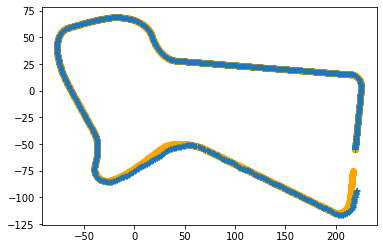

In [24]:
track = trajectory[didx*a:didx*a + len(zs.T), :3].T
plt.plot(track[0, :], track[1, :], '-o', color="orange")
plt.plot(zs[0, :], zs[1, :], '-+')
plt.show()

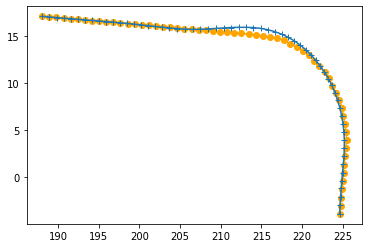

In [32]:
track = trajectory[didx*4:didx*7, :3].T
plt.plot(track[0, :], track[1, :], '-o', color="orange")
plt.plot(zs[0, didx*4:didx*7], zs[1, didx*4:didx*7], '-+')
plt.show()

In [26]:
len(zs.T)

us

array([[ 0.2003067 ,  0.25611522,  0.0351457 , ...,  0.10116743,
         0.14344536,  0.        ],
       [ 0.43846719,  0.41049394,  0.32280614, ...,  0.52023739,
         0.41507624,  0.        ],
       [-0.25732713, -0.2468346 , -0.28237719, ...,  0.0174652 ,
        -0.00537982,  0.        ]])

In [27]:
for action in us.T:
    try:
        # render environment 
        env.render()

        observation = env.step(action)
    except KeyboardInterrupt:
        done = True

In [28]:
len(trajectory)

1000

In [29]:
# opti = casadi.Opti();

# u = opti.variable(3, N-1);
# u_init = np.tile([[0], [.5], [0]], (1, N-1))
# opti.set_initial(u, u_init)

# z_0 = np.zeros((6, 1))
# z_0[:3] = track.T[:3, 0:1]

# z = MX(z_0)

# cost = 0

# for i in range(N-1):
#     cost += (z[:3] - z_ref[:, i]).T @ Q @ (z[:3] - z_ref[:, i]) + u[:, i].T @ R @ u[:, i]
#     z[:3] = z[:3] + z[3:] * dt
#     z[3:] = z[3:] + f(z[:], u[:, i], model) * dt

# cost += (z[:3] - z_ref[:, N-1]).T @ Q @ (z[:3] - z_ref[:, N-1])

# opti.minimize(cost);

# opti.solver('ipopt');

# sol = opti.solve();

In [30]:
# z = z_0.squeeze()
# zs = [z]

# for i in range(N-1):
#     a = model.predict([z.reshape(1, -1), u_opt[:, i].reshape(1, -1)])[0]
#     z_next = np.zeros((6,))
#     z_next[:3] = z[:3] + z[3:] * dt
#     z_next[3:] = z[3:] + a * dt
#     zs.append(z_next)
#     z = z_next

# zs = np.array(zs)

# plt.plot(track[:, 0], track[:, 1], '-o')
# plt.plot(zs[:, 0], zs[:, 1], '-+')
# plt.show()